In [1]:
import pickle
with open('datasets_analysis.pickle', "rb") as f:
    datasets_analysis = pickle.load(f)
train_datasets, train_reason, train_err_fact_qty, test_datasets, test_reason, test_err_fact_qty= datasets_analysis

In [2]:
# 일단 불량 데이터만 뽑아내기
# 관련성 어떻게??

# 일단 labeled 데이터로 머신러닝
# unlabeled 데이터로 pred
# 결과로 나온 label과 pred 의 수치를 비교하여 관련성 분석
# 시나리오
# 정상 / 불량 데이터 분리
# 정상 데이터 평균, 불량 데이터 평균 비교

In [3]:
pickup_train_err_data = list()
for td, tr in zip(train_datasets, train_reason):
    if tr.argmax()==0: continue
    elif tr.argmax()==1:
        pickup_train_err_data.append((td, 1))
    elif tr.argmax()==2:
        pickup_train_err_data.append((td, 2))
    elif tr.argmax()==3:
        pickup_train_err_data.append((td, 3))

In [4]:
import torch
from torch import nn
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.out_classes = 3
        self.down = nn.Sequential(            
            self._block_down(self.in_features, self.in_features*2),           
            self._block_down(self.in_features*2, self.in_features*2),           
            self._block_down(self.in_features*2, self.in_features),           
            self._block_down(self.in_features, self.in_features//2),           
            self._block_down(self.in_features//2, self.in_features//4),           
            self._block_down(self.in_features//4, self.out_classes),                       
            # nn.Tanh()
        )
        self.up = nn.Sequential(
            self._block_down(self.out_classes,self.in_features//4),
            self._block_down(self.in_features//4,self.in_features//2),
            self._block_down(self.in_features//2,self.in_features),
            self._block_down(self.in_features,self.in_features*2),
            self._block_down(self.in_features*2,self.in_features*2),
            self._block_down(self.in_features*2,self.in_features*2),
            self._block_down(self.in_features*2,self.in_features),
            # nn.Tanh() # 여기만 다시 활성화       효과없음     
        )
        self.essens=None
    
    def _block_down(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Linear(in_channels,out_channels),
            nn.Mish(True),
            nn.Dropout(0.5)
        )
    def _block_up(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Linear(in_channels,out_channels),
            nn.Mish(True),
            nn.Dropout(0.5)
        )
    def forward(self, x):
        self.essens = self.down(x)
        x2 = self.up(self.essens)
        return x2
    def get_vector(self, x):
        self.essens = self.down(x)
        return self.essens

IN_FEATURES = pickup_train_err_data[0][0].shape[0]
critic = Discriminator(IN_FEATURES).eval()

In [5]:
BEST_MODEL_PATH = 'best_model_AE_1_1.pth'
critic.load_state_dict(torch.load(BEST_MODEL_PATH))
# critic = critic.to('cuda')

<All keys matched successfully>

In [6]:

import numpy as np
train_vector=list()

for dt, dr in pickup_train_err_data:    
    ret = critic.get_vector(torch.from_numpy(dt).float())
    ret_ = ret.detach().cpu().numpy()
    out = np.hstack([ret_, dr])
    train_vector.append(out)

In [7]:
train_vector[1]

array([8.22890568, 7.50349712, 9.57115936, 1.        ])

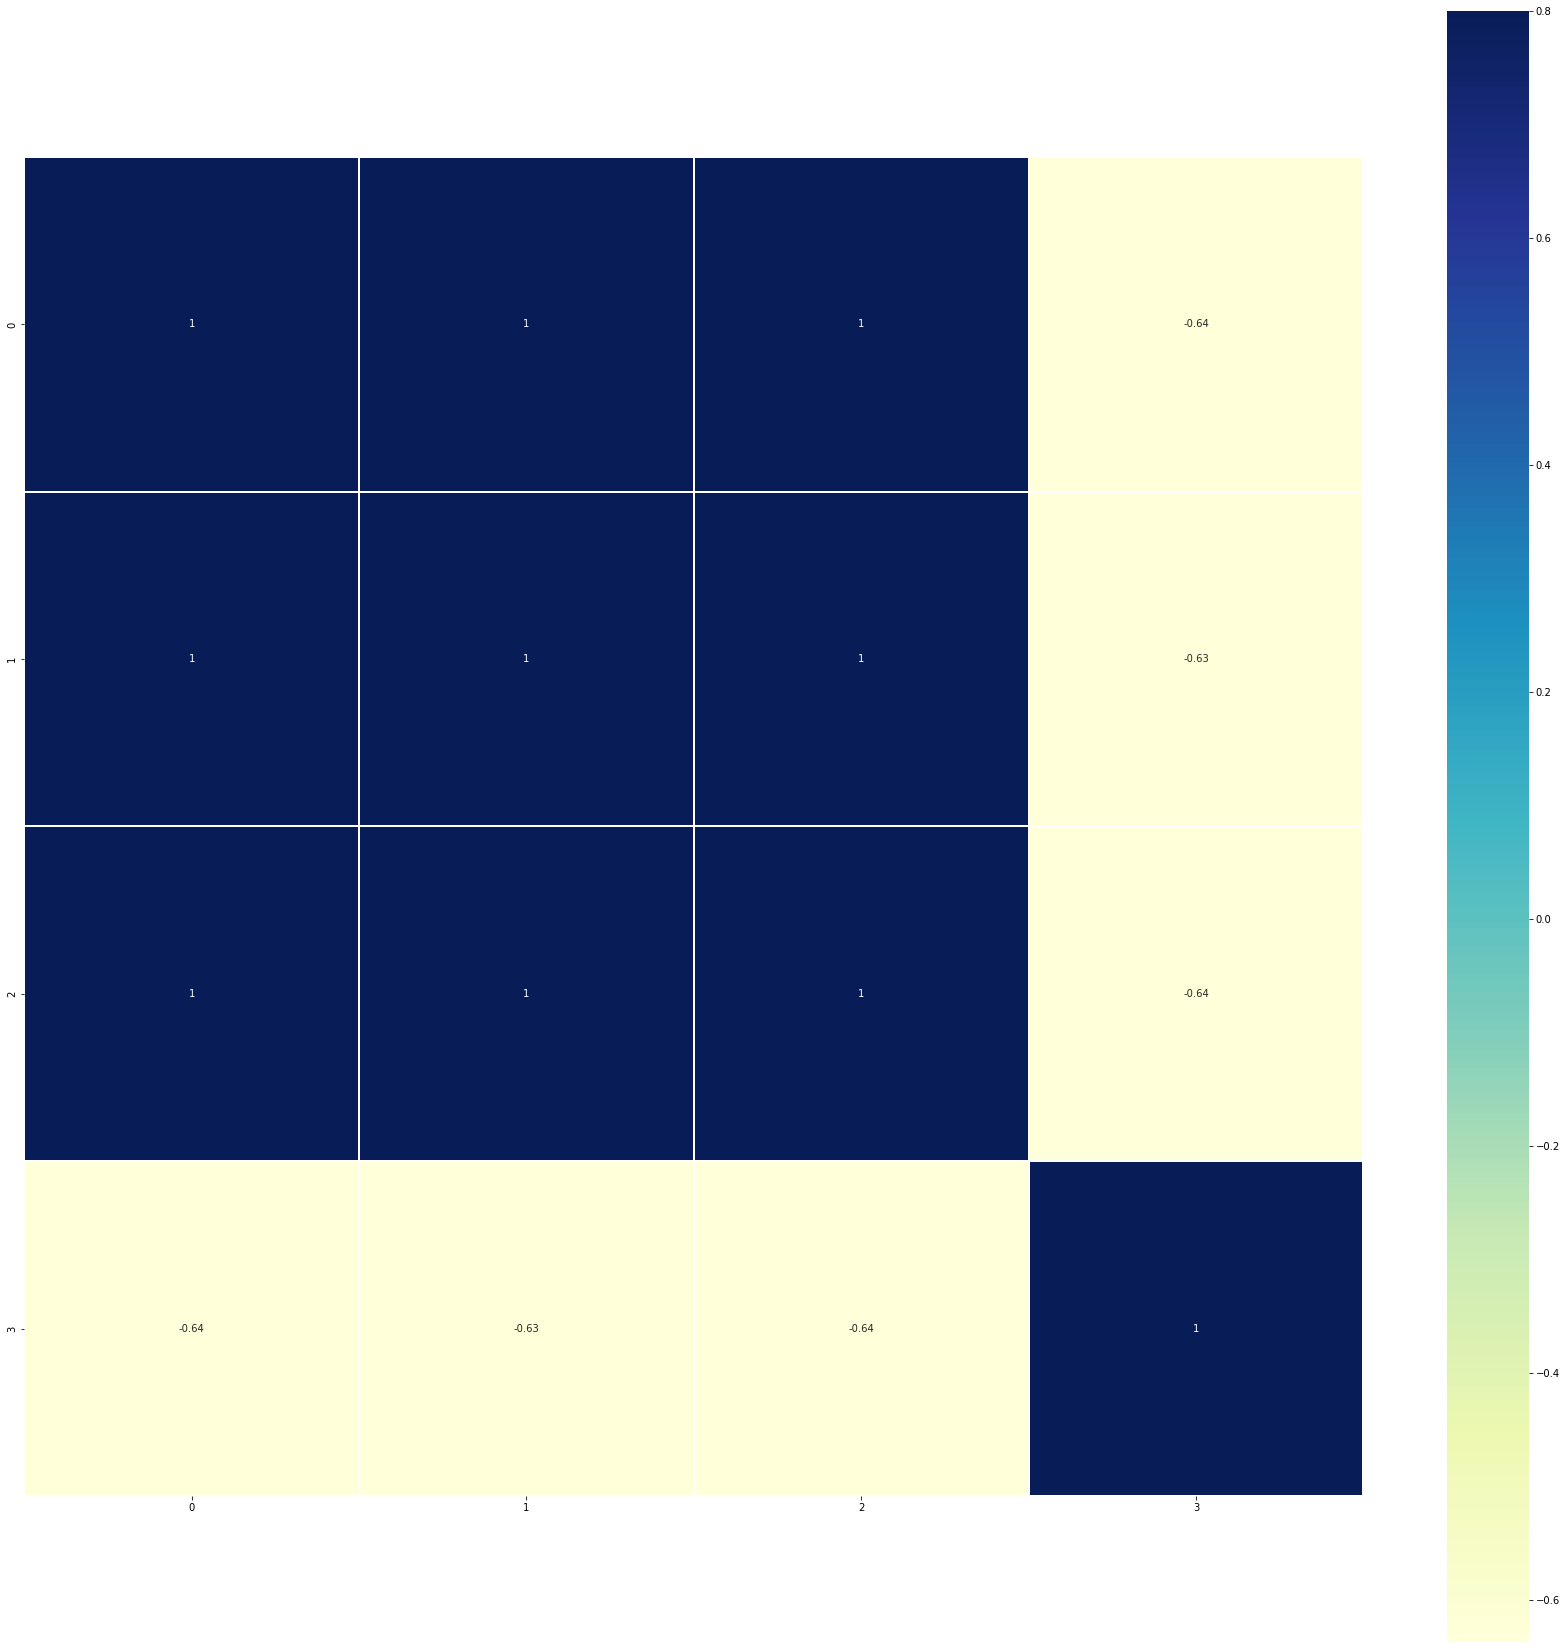

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
labeled = pd.DataFrame(train_vector)
corr = labeled.corr()
plt.figure(figsize=(30, 30));
sns.heatmap(corr,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu',);
plt.show()

In [18]:
h, w = np.array(train_vector)[:,:-1].shape
np.sum(np.array(train_vector)[:,:-1])/(h*w)

8.572609652661615

In [34]:
sum_1=list()
sum_2=list()
sum_3=list()
for vec in train_vector:
    if vec[-1] ==1:
        sum_1.append(vec)
    elif vec[-1]==2:
        sum_2.append(vec)
    elif vec[-1]==3:
        sum_3.append(vec)

In [35]:
abc = [sum_1, sum_2, sum_3]
for a in abc:
    tmp= np.array(a)
    t = tmp[:,:-1]
    print(tmp.shape)
    h, w = t.shape
    print(np.sum(tmp[:,:-1])/(h*w))

(35, 4)
9.275301787966773
(15, 4)
9.28716098997328
(10, 4)
5.041360173126062


In [64]:
tmp

array([[ 7.41931963,  6.79147243,  8.63696766,  3.        ],
       [ 7.20056343,  6.59893847,  8.38512516,  3.        ],
       [ 0.25102848,  0.2327276 ,  0.33850002,  3.        ],
       [-0.1525041 , -0.16150026, -0.15757087,  3.        ],
       [ 5.97452784,  5.51245403,  6.97178602,  3.        ],
       [ 5.67782259,  5.24747515,  6.62904596,  3.        ],
       [ 4.55516624,  4.23787689,  5.33326674,  3.        ],
       [ 5.13744593,  4.76312351,  6.00596952,  3.        ],
       [ 6.29455853,  5.79709482,  7.34106445,  3.        ],
       [ 6.60561752,  6.07333899,  7.70010281,  3.        ]])

In [47]:
pickup_test_err_data = list()
for td, tr in zip(test_datasets, test_err_fact_qty):
    if tr==0.: continue
    pickup_test_err_data.append((td, tr))    

In [63]:
test_vector=list()

for dt, dr in pickup_test_err_data:    
    ret = critic.get_vector(torch.from_numpy(dt).float())
    ret_ = ret.detach().cpu().numpy()
    out = np.hstack([ret_, dr])
    print(ret_)
    test_vector.append(out)
    break

[48788.71  42759.473 56126.82 ]


In [69]:
pickup_train_err_data[0][0]

array([ 2.57185358e+00,  2.47831552e-02,  3.49353595e-01,  7.40169012e-01,
        8.75229570e-02,  8.08617110e-01,  1.46110812e+00, -5.67561921e-01,
        1.29185582e-01,  2.36885613e-01,  2.75595831e-01,  4.51755514e-01,
        1.41421865e+00,  6.64975913e-01,  1.11014215e+00,  1.08659424e+00,
        1.10612448e+00,  1.48725633e+00,  9.19941549e-01,  7.54749482e-01,
        6.16257802e-01, -1.91239462e-01, -7.63867076e-01, -1.40729879e+00,
        1.06615580e+00,  0.00000000e+00,  0.00000000e+00,  2.50000000e+01,
        2.75000000e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [70]:
critic.get_vector(torch.from_numpy(np.array(pickup_train_err_data[0][0])).float())

tensor([ 8.6081,  7.8352, 10.0071], grad_fn=<MishBackward0>)

In [52]:
output = [[]]*353
output

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [62]:
for vec in test_vector:
    vec=np.array(vec)
    idx = vec[-1]-1
    output[int(idx)].append(np.sum(vec[:-1]))
    print(vec)
    break

[4.87887109e+04 4.27594727e+04 5.61268203e+04 1.10000000e+01]


In [55]:
for id, out in enumerate(output):
    print(id, np.mean(out))

0 157636.96652300673
1 157636.96652300673
2 157636.96652300673
3 157636.96652300673
4 157636.96652300673
5 157636.96652300673
6 157636.96652300673
7 157636.96652300673
8 157636.96652300673
9 157636.96652300673
10 157636.96652300673
11 157636.96652300673
12 157636.96652300673
13 157636.96652300673
14 157636.96652300673
15 157636.96652300673
16 157636.96652300673
17 157636.96652300673
18 157636.96652300673
19 157636.96652300673
20 157636.96652300673
21 157636.96652300673
22 157636.96652300673
23 157636.96652300673
24 157636.96652300673
25 157636.96652300673
26 157636.96652300673
27 157636.96652300673
28 157636.96652300673
29 157636.96652300673
30 157636.96652300673
31 157636.96652300673
32 157636.96652300673
33 157636.96652300673
34 157636.96652300673
35 157636.96652300673
36 157636.96652300673
37 157636.96652300673
38 157636.96652300673
39 157636.96652300673
40 157636.96652300673
41 157636.96652300673
42 157636.96652300673
43 157636.96652300673
44 157636.96652300673
45 157636.9665230067

In [61]:
output[2]

[147675.00390625,
 -0.7756124883890152,
 -0.7767536342144012,
 -0.7403948158025742,
 -0.739404946565628,
 -0.741881713271141,
 -0.740937203168869,
 -0.7454062253236771,
 -0.7445686608552933,
 -0.7474191933870316,
 -0.7466155290603638,
 -0.7509324699640274,
 -0.750230148434639,
 -0.7534774094820023,
 -0.7528657764196396,
 -0.7562445551156998,
 -0.7557793855667114,
 -0.7575058192014694,
 -0.7571024745702744,
 -0.756680503487587,
 -0.7562387138605118,
 -0.7581976056098938,
 -0.7578154355287552,
 -0.7586875408887863,
 -0.7583156228065491,
 -0.7598166763782501,
 -0.7594979852437973,
 -0.7615195512771606,
 -0.7612941414117813,
 -0.7636129856109619,
 -0.7634673565626144,
 -0.7635615170001984,
 -0.7634191811084747,
 -0.7651702165603638,
 -0.7651111483573914,
 -0.7655531615018845,
 -0.7655267864465714,
 -0.7668558061122894,
 -0.7668927907943726,
 -0.7672339677810669,
 -0.7672714293003082,
 -0.7675489634275436,
 -0.7676071971654892,
 -0.7676929235458374,
 -0.7677666395902634,
 -0.768615901470184